## Data Summary  
#### Import Python Lirbaries

In [1]:
# Configure TF logging and GPU memory behaviour
import os
import logging
import warnings

# Set TF C++ logging level BEFORE importing tensorflow to suppress low-level messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # 0=DEBUG,1=INFO,2=WARNING,3=ERROR
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# Reduce Python-level TF logging
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Optionally suppress specific noisy UserWarnings from Keras/TF
warnings.filterwarnings('ignore', message=r'Your input ran out of data; interrupting training.*', category=UserWarning)
warnings.filterwarnings('ignore', message=r'.*Local rendezvous.*', category=UserWarning)

# Keep memory growth setting
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Import core libraries and ML utilities
import math, glob, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras import layers, models

# Set random seeds for reproducibility
tf.random.set_seed(666)
np.random.seed(666)

#### Import Datasets

In [3]:
# Paths to data folders and labels file
train_images_path = './train/'
test_images_path  = './test/'
train_labels_csv  = './train_labels.csv'

# Image and pipeline configuration
IMG_SIZE = 96              # target size to resize patches to
CHANNELS = 3               # RGB images
AUTOTUNE = tf.data.AUTOTUNE # let tf.data choose parallelism
SHARD_SIZE = 2048          # number of examples per TFRecord shard
BATCH_SIZE = 64            # training batch size

In [4]:
# Create a list of the file paths to the images in the train and test folders
train_file_paths = glob.glob(os.path.join(train_images_path, '*.tif'))
test_file_paths = glob.glob(os.path.join(test_images_path, '*.tif'))

print(f'Count of train images = {len(train_file_paths):,}\nCount of test images = {len(test_file_paths):,}')

Count of train images = 220,025
Count of test images = 57,458


In [5]:
# Load training labels
labels_df = pd.read_csv(train_labels_csv)

# Create a vector of the training labels
train_labels_vec = labels_df['label'].astype(np.int8).values

#### Convert Files to TensorFlow Records
Intention: write compact TFRecords using JPEG-encoded bytes for fast TensorFlow ingestion  
Outcome: sharded TFRecords with simple features

In [6]:
# Create folders to store .tfrec files (if not present)
os.makedirs('./tfrecords/train', exist_ok=True)
os.makedirs('./tfrecords/test',  exist_ok=True)

# Function to convert a .tif to JPEG bytes
def load_tif_as_jpeg_bytes(path):
    img = Image.open(path).convert('RGB')
    # Ensure images are the expected size for the model
    if img.size != (IMG_SIZE, IMG_SIZE):
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    from io import BytesIO
    buf = BytesIO()
    img.save(buf, format='JPEG', quality=95)  # store as high-quality JPEG
    return buf.getvalue()

# Helper helpers to encode features into tf.train.Example
def bytes_feature(_bytes_):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[_bytes_]))
def int_feature(_value_):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[int(_value_)]))

# Create sharded TFRecords from a list of image paths
def create_tfrecords(image_paths, labels, outdir, shard_size):
    n = len(image_paths)
    nshards = math.ceil(n / shard_size)
    for s in range(nshards):
        start_file_num = s * shard_size
        end_file_num = min((s + 1) * shard_size, n)
        shard_filename = f'part_{start_file_num}-{end_file_num-1}.tfrec'
        shard_path = os.path.join(outdir, shard_filename)
        if shard_filename in os.listdir(outdir):
            print(f'\tSkipping {shard_path}, already exists.')
            pass
        else:
            with tf.io.TFRecordWriter(shard_path, options='GZIP') as w:
                for i in range(start_file_num, end_file_num):
                    img_bytes = load_tif_as_jpeg_bytes(image_paths[i])
                    features = {
                        # Store the image metadata
                        'image':    bytes_feature(img_bytes),
                        'height':   int_feature(IMG_SIZE),
                        'width':    int_feature(IMG_SIZE),
                        'channels': int_feature(CHANNELS),
                        'id':       bytes_feature(os.path.basename(image_paths[i]).replace('.tif','').encode()),
                    }
                    if labels is not None:
                        # Label only need for the training shards
                        features['label'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[int(labels[i])]))
                    example = tf.train.Example(features=tf.train.Features(feature=features))
                    w.write(example.SerializeToString())
            print(f'\t Created {shard_path}')

# Convert train images to TFRecords
print('Creating train tfrecords:')
create_tfrecords(train_file_paths, train_labels_vec, './tfrecords/train', SHARD_SIZE)

# Convert test images to TFRecords
print('\nCreating test tfrecords:')
create_tfrecords(test_file_paths, None, './tfrecords/test', SHARD_SIZE)

Creating train tfrecords:
	Skipping ./tfrecords/train/part_0-2047.tfrec, already exists.
	Skipping ./tfrecords/train/part_2048-4095.tfrec, already exists.
	Skipping ./tfrecords/train/part_4096-6143.tfrec, already exists.
	Skipping ./tfrecords/train/part_6144-8191.tfrec, already exists.
	Skipping ./tfrecords/train/part_8192-10239.tfrec, already exists.
	Skipping ./tfrecords/train/part_10240-12287.tfrec, already exists.
	Skipping ./tfrecords/train/part_12288-14335.tfrec, already exists.
	Skipping ./tfrecords/train/part_14336-16383.tfrec, already exists.
	Skipping ./tfrecords/train/part_16384-18431.tfrec, already exists.
	Skipping ./tfrecords/train/part_18432-20479.tfrec, already exists.
	Skipping ./tfrecords/train/part_20480-22527.tfrec, already exists.
	Skipping ./tfrecords/train/part_22528-24575.tfrec, already exists.
	Skipping ./tfrecords/train/part_24576-26623.tfrec, already exists.
	Skipping ./tfrecords/train/part_26624-28671.tfrec, already exists.
	Skipping ./tfrecords/train/part_2

## Exploratory Data Analysis (EDA)

In this section we inspect the data visually and numerically.  We load a handful of sample images from each class to examine typical patterns and variations.  Because the images are stored as TIFF files, we use the Pillow library to read them.  We also compute basic statistics such as the mean and standard deviation of pixel intensities per channel to inform normalisation strategies.

The class distribution plot above shows that the dataset is slightly imbalanced (≈59 % negative vs 41 % positive).  To mitigate bias during training, you may explore class weighting or resampling strategies.

#### Distribution of Labels
- Understand balance of dataset

Class counts:
label
0    130908
1     89117
Name: count, dtype: int64


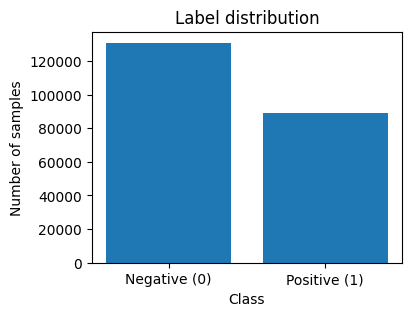

In [7]:
# Inspect label distribution
class_counts = labels_df['label'].value_counts().sort_index()
print('Class counts:')
print(class_counts)

# Plot label distribution
plt.figure(figsize=(4,3))
plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values)
plt.title('Label distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

#### Sample of Training Data Images

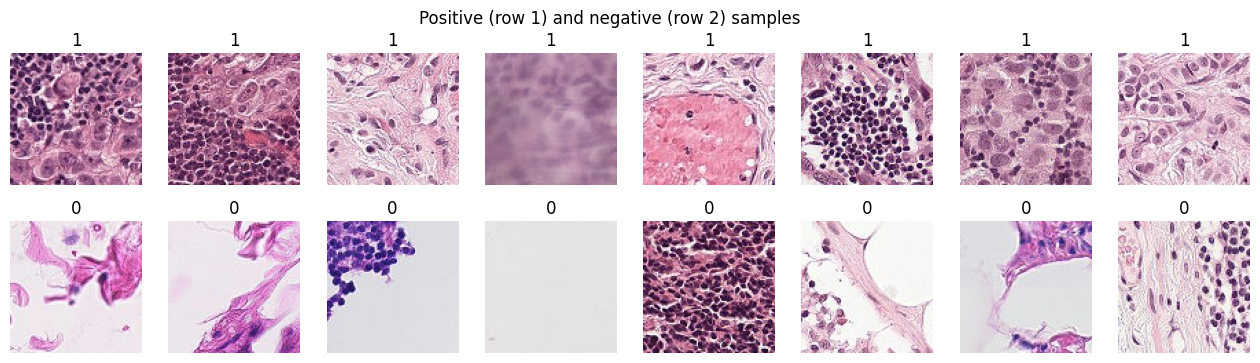

In [8]:
# Visualize random samples from each class
def load_image(img_id, directory):
    file_path = os.path.join(directory, f'{img_id}.tif')
    return Image.open(file_path)

positive_ids = labels_df[labels_df['label'] == 1]['id'].sample(8).tolist()
negative_ids = labels_df[labels_df['label'] == 0]['id'].sample(8).tolist()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, img_id in enumerate(positive_ids):
    img = load_image(img_id, train_images_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('1')

for i, img_id in enumerate(negative_ids):
    img = load_image(img_id, train_images_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('0')

plt.suptitle('Positive (row 1) and negative (row 2) samples')
plt.show()

Based on the EDA, the following observations guide our analysis:

- The label distribution shows a moderate class imbalance; using class weights or oversampling may help the model focus on minority (positive) samples.
- The images have strong staining variability and sometimes contain artefacts; data augmentation (random flips, rotations, brightness/contrast adjustments) can improve generalisation.

**Analysis plan:**

1. Split the labelled data into training and validation sets (e.g. 80/20).
2. Preprocess images: resize to a common size (96×96), apply augmentations on the fly, and normalise by global channel statistics.
3. Train several CNN architectures ranging from a simple custom CNN to transfer learning models (e.g. ResNet50, DenseNet169).
4. Tune hyperparameters such as learning rate, optimiser, dropout rate, batch size and number of layers using a search strategy (random search or Bayesian optimisation).
5. Evaluate the models on the validation set using metrics appropriate for class imbalance (AUC, precision, recall, F1).

## CNN Modeling

#### Train - Validation Split
- The Kaggle dataset only provides labels for the training images, so we will need to subdivide the training images into a training and validation set (80% training, 20% validation) in order to be able to test the performace of the CNN models.

In [9]:
# Create indicies along which to split data into training and validation sets 
train_idx, val_idx = train_test_split(
    np.arange(len(labels_df)),
    test_size=0.20,
    random_state=666,
    stratify=train_labels_vec
)

# Create vectors of training and validation labels
train_labels = train_labels_vec[train_idx]
val_true_labels = train_labels_vec[val_idx]

# Save split file lists for consistent TFRecord selection later
split_meta = {
    'train_ids': labels_df['id'].iloc[train_idx].tolist(),
    'val_ids':   labels_df['id'].iloc[val_idx].tolist(),
}
with open('./tfrecords/split.json','w') as f: json.dump(split_meta, f)

print(len(train_labels), len(val_true_labels))

176020 44005


#### Create Datasets

In [10]:
# Feature descriptions used to parse TFRecord Examples
feature_desc_train = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width':  tf.io.FixedLenFeature([], tf.int64),
    'channels': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}
feature_desc_test = {k:v for k,v in feature_desc_train.items() if k!='label'}  # no label for test

# Parser function to convert serialized Example into (image_tensor, label) tuples
def parse_train(example):
    # Parse TFRecord and decode JPEG bytes to float32 tensor in [0,1]
    ex = tf.io.parse_single_example(example, feature_desc_train)
    img = tf.io.decode_jpeg(ex['image'], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # 0..1 range
    label = tf.cast(ex['label'], tf.int32)
    return img, label

# Parsers function to convert serialized Example into (image_tensor, id) tuples
def parse_test(example):
    ex = tf.io.parse_single_example(example, feature_desc_test)
    img = tf.io.decode_jpeg(ex['image'], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, ex['id']

# Helper function to return the list of TFRecord shards for a split and a tensor of ids used for filtering
def tfrecord_files_for(split_ids, directory='./tfrecords/train'):
    return sorted(glob.glob(os.path.join(directory, '*.tfrec'))), tf.constant(split_ids)

# Load saved split metadata and build dataset file lists
with open('./tfrecords/split.json') as f: meta = json.load(f)
train_files_tfrec, train_ids_tensor = tfrecord_files_for(meta['train_ids'])
val_files_tfrec, val_ids_tensor = tfrecord_files_for(meta['val_ids'])

# Build lookup tables to quickly filter examples by id when reading shards
train_ids_values = tf.ones(tf.shape(train_ids_tensor), dtype=tf.int32)
val_ids_values = tf.ones(tf.shape(val_ids_tensor), dtype=tf.int32)

train_ids_lookup = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(train_ids_tensor, train_ids_values), default_value=0)
val_ids_lookup = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(val_ids_tensor, val_ids_values), default_value=0)

# Filter functions used after parsing to keep only records in the chosen split
def filter_by_ids_train(img, label, ex_id):
    keep = train_ids_lookup.lookup(ex_id) > 0
    return keep
def filter_by_ids_val(img, label, ex_id):
    keep = val_ids_lookup.lookup(ex_id) > 0
    return keep

# Parser functions to return the id to filter by then drop the id column for training
def parse_train_with_id(example):
    ex = tf.io.parse_single_example(example, feature_desc_train)
    img = tf.io.decode_jpeg(ex['image'], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    label = tf.cast(ex['label'], tf.int32)
    return img, label, ex['id']
def strip_id(img, label, ex_id):
    return img, label

# Build training dataset
train_ds = (
    tf.data.TFRecordDataset(train_files_tfrec, compression_type='GZIP', num_parallel_reads=AUTOTUNE)
    .map(parse_train_with_id, num_parallel_calls=AUTOTUNE)
    .filter(filter_by_ids_train)
    .map(strip_id, num_parallel_calls=AUTOTUNE)
    .shuffle(8192, seed=666, reshuffle_each_iteration=True)  # mixing
    .repeat()    # <- make infinite so Keras consumes steps_per_epoch batches per epoch
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Build validation dataset
val_ds = (
    tf.data.TFRecordDataset(val_files_tfrec, compression_type='GZIP', num_parallel_reads=AUTOTUNE)
    .map(parse_train_with_id, num_parallel_calls=AUTOTUNE)
    .filter(filter_by_ids_val)
    .map(strip_id, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Build test dataset
test_ds = (
    tf.data.TFRecordDataset(sorted(glob.glob('./tfrecords/test/*.tfrec')), compression_type='GZIP', num_parallel_reads=AUTOTUNE)
    .map(parse_test, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

I0000 00:00:1762044535.201752   18036 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1762044535.201983   18036 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


#### Model Fitting & Evaluations Helper Functions

In [11]:
# Function used to fit a CNN model (or load from the directory if a fit model already exists)
def fit_CNN_model(model):
    checkpoint_path = f'{model.name}_best_model.weights.h5'
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='AUC', mode='max', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='AUC', mode='max', save_best_only=True, save_weights_only=True)
    ]

    # compute steps_per_epoch from the saved split metadata
    import math
    try:
        n_train = len(meta['train_ids'])  # meta was loaded when building datasets
    except Exception:
        # fallback: estimate from train_ids_tensor if meta is not available
        n_train = int(tf.size(train_ids_tensor).numpy())
    steps_per_epoch = math.ceil(n_train / BATCH_SIZE)

    if not os.path.exists(checkpoint_path):
        # Fit and return the History object
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=30,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks,
            verbose=1,
        )
        return history
    else:
        model.load_weights(checkpoint_path)
        print(f'Loaded existing weights from {checkpoint_path}')
        return model

In [12]:
# Function used to create evaluation outputs


#### Baseline CNN Model

In [13]:
# Function to create an instance of baseline CNN model
def make_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    aug = models.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.10),
        layers.RandomZoom(0.10),
        layers.RandomContrast(0.10),
        layers.Rescaling(1./255),
    ], name='preprocess')

    x_in = layers.Input(shape=input_shape)
    x = aug(x_in)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(x_in, out, name='baseline_cnn_model')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC','accuracy'])
    return model

# Create the baseline model instance
baseline_cnn_model = make_baseline_cnn()

# Display baseline model structure
baseline_cnn_model.summary()

Model: "baseline_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Fit the baseline model
fit_model = fit_CNN_model(baseline_cnn_model)
fit_model

Epoch 1/30
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 155s 54ms/step - AUC: 0.4999 - accuracy: 0.5947 - loss: 0.6753 - val_AUC: 0.5000 - val_accuracy: 0.5947 - val_loss: 0.6752
Epoch 2/30
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 155s 54ms/step - AUC: 0.4999 - accuracy: 0.5947 - loss: 0.6753 - val_AUC: 0.5000 - val_accuracy: 0.5947 - val_loss: 0.6752
Epoch 2/30
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 176s 64ms/step - AUC: 0.5018 - accuracy: 0.5950 - loss: 0.6752 - val_AUC: 0.5000 - val_accuracy: 0.5947 - val_loss: 0.6752
Epoch 3/30
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 176s 64ms/step - AUC: 0.5018 - accuracy: 0.5950 - loss: 0.6752 - val_AUC: 0.5000 - val_accuracy: 0.5947 - val_loss: 0.6752
Epoch 3/30
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 144s 53ms/step - AUC: 0.5024 - accuracy: 0.5951 - loss: 0.6751 - val_AUC: 0.5000 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 4/30
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 144s 53ms/step - AUC: 0.5024 - accuracy: 0.5951 - loss: 0.6751 - val_AUC: 0.5000 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 4/30

## Results & Analysis
- Discuss and interpret results

#### Kaggle Submission

In [15]:
# Get best model
# best_model = 

# Predict labels for test images


# Convert prediction into Kaggle submission format


In [16]:
# Image of Kaggle submission


## Conclusion
- Summarize project
- Learnings and takeaways
- What did and did not help improve the performance of your models
- What improvements could you try in the future